In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Rice_Image_Dataset.zip', 'r')
zip_ref.extractall('/content/dataset')  # Extract to a folder
zip_ref.close()

In [ ]:
import gdown

file_id = "1tBErPfzgWNWxU20NtqwCpgcPtT306ZmC"
zip_filename = "data.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_filename, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1tBErPfzgWNWxU20NtqwCpgcPtT306ZmC
From (redirected): https://drive.google.com/uc?id=1tBErPfzgWNWxU20NtqwCpgcPtT306ZmC&confirm=t&uuid=18b1492f-febf-442e-b5c6-0f93aa70132e
To: /content/data.zip
100%|██████████| 4.17G/4.17G [00:51<00:00, 80.2MB/s]


'data.zip'

In [ ]:
import zipfile

extract_path = "./dataset"  

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


In [ ]:
import gdown

file_id = "1_9ADdI5w0--Y6dWUKF9wnb6doyKqtYf0"
zip_filename = "dataset.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_filename, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1_9ADdI5w0--Y6dWUKF9wnb6doyKqtYf0
From (redirected): https://drive.google.com/uc?id=1_9ADdI5w0--Y6dWUKF9wnb6doyKqtYf0&confirm=t&uuid=1b75beca-25a9-4755-a45c-d7318cceed78
To: /content/dataset.zip
100%|██████████| 2.19G/2.19G [00:29<00:00, 75.1MB/s]


'dataset.zip'

In [ ]:
import zipfile

extract_path = "./dataset" 

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import glob

root_path = 'dataset'

class_names = [d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
print("Class Names:", class_names)

filepaths = list(glob.glob(os.path.join(root_path, '*', '*.*')))
labels = [os.path.split(os.path.split(fp)[0])[1] for fp in filepaths]

data = pd.DataFrame({'Filepath': filepaths, 'Label': labels})

train, test = train_test_split(data, test_size=0.25, random_state=42, stratify=data['Label'])

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  
    color_mode='rgb',  
    class_mode='categorical', 
    batch_size=32,  
    shuffle=False  
)


Class Names: ['avg', 'good', 'bad']
Found 635 validated image filenames belonging to 3 classes.


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

base_path = r"dataset"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    validation_split=0.2, 
    rotation_range=25, 
    width_shift_range=0.2, 
    height_shift_range=0.2,  
    horizontal_flip=True,  
    zoom_range=0.2 
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    validation_split=0.2 
)


KeyError: 'filename'

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',  
    y_col='Label',
    target_size=(224, 224),  
    color_mode='rgb',  
    batch_size=32,  
    class_mode='categorical',  
    subset='training',  
    shuffle=True,  
    seed=1  
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',  
    y_col='Label',
    target_size=(224, 224),  
    color_mode='rgb',  
    batch_size=32,  
    class_mode='categorical',  
    subset='validation',  
    shuffle=False,  
    seed=1  
)
print("Class indices:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)

Found 1524 validated image filenames belonging to 3 classes.
Found 381 validated image filenames belonging to 3 classes.
Class indices: {'avg': 0, 'bad': 1, 'good': 2}


In [ ]:
base_model = ResNet50(
    weights='imagenet',  
    include_top=False, 
    input_shape=(224, 224, 3)  
)
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.4)(x)  
outputs = Dense(num_classes, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.0001),  
    loss='categorical_crossentropy',  
    metrics=['accuracy']  
)

model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  
)

model.save("rice_grad_resnet50.h5")
print("Model saved successfully!")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.5815 - loss: 0.9784 - val_accuracy: 0.9659 - val_loss: 0.1426
Epoch 2/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9375 - loss: 0.2179

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 656ms/step - accuracy: 0.9375 - loss: 0.2179 - val_accuracy: 0.9659 - val_loss: 0.1418
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.9383 - loss: 0.1947 - val_accuracy: 0.9517 - val_loss: 0.1488
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 680ms/step - accuracy: 1.0000 - loss: 0.0976 - val_accuracy: 0.9517 - val_loss: 0.1344
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.9712 - loss: 0.0990 - val_accuracy: 0.9432 - val_loss: 0.1579
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 591ms/step - accuracy: 0.9375 - loss: 0.1925 - val_accuracy: 0.9403 - val_loss: 0.1623
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.9707 - loss: 0.0947 - val_accuracy: 0.9233 - val_loss: 0.1766
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 898ms/step - accuracy: 0.9375 - loss: 0.1331 - val_accuracy: 0.9347 - val_loss: 0.1640
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.9846 - loss: 0.0585 - val_accuracy: 0.9602 - val_

Model saved successfully!


In [ ]:
print("Test Generator:")
print(f"Number of images: {test_generator.samples}")
print(f"Class indices: {test_generator.class_indices}")

Test Generator:
Number of images: 635
Class indices: {'avg': 0, 'bad': 1, 'good': 2}


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.9746 - loss: 0.0832
Test Loss: 0.0833
Test Accuracy: 0.9654


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  

y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step
Confusion Matrix:
[[210   0   0]
 [ 22 128   0]
 [  0   0 275]]
Classification Report:
              precision    recall  f1-score   support

         avg       0.91      1.00      0.95       210
         bad       1.00      0.85      0.92       150
        good       1.00      1.00      1.00       275

    accuracy                           0.97       635
   macro avg       0.97      0.95      0.96       635
weighted avg       0.97      0.97      0.96       635



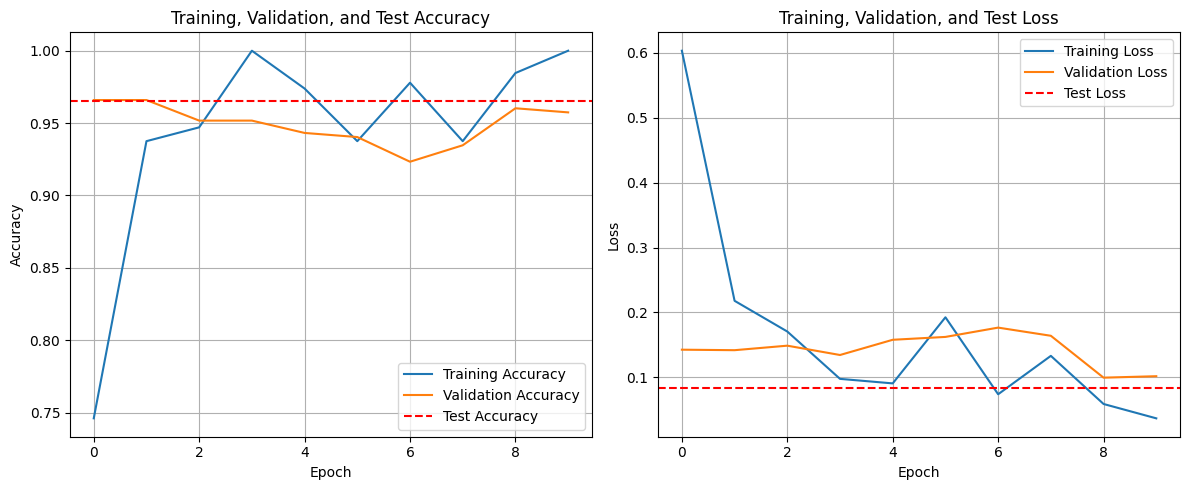

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Add test accuracy
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

model = tf.keras.models.load_model("rice_grad_resnet50.h5")

img_path = '/content/IMG20250320151927_BURST016_90.jpg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)

predicted_class_index = np.argmax(preds[0])

class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class name: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class index: 1
Predicted class name: bad
